# EEE 482 Project - Visual Object Recognition (Haxby Dataset)

### Notebook prepared by Efe Acer, Hygerta Imeri and Gorkem Erturk

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import nibabel as nib
import csv
import pandas as pd
from nibabel.testing import data_path
from nilearn import plotting as nplt
from nilearn.input_data import NiftiMasker
from sklearn.model_selection import LeaveOneGroupOut, cross_val_score
from scipy.spatial.distance import cdist # Python equivalent of pdist2
#from sklearn.metrics import accuracy_score, log_loss
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC, NuSVC
from sklearn.tree import DecisionTreeClassifier
#from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.decomposition import PCA
#from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from mpl_toolkits.mplot3d import Axes3D

/Users/user/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
/Users/user/anaconda3/lib/python3.6/site-packages/nilearn/plotting/__init__.py:20: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "/Users/user/anaconda3/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/Users/user/anaconda3/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/Users/user/anaconda3/lib/python3.6/site-package

# Data Preparation

In the Haxby dataset, there exists 8 stimuli categories, which are gray scale images of the objects given in the array below:

In [2]:
LABELS = ['scissors', 'face', 'cat', 'scrambledpix', 'bottle', 'chair', 'shoe', 'house']

The FMRI data points and the stimuli data points given in the dataset are probed in different time scales, the code below maps the FMRI data points based on the stimuli data's time scale.

In [3]:
FMRI_STIMULI_LENGTH = 9
fmri_startpoints = [6, 21, 35, 49, 63, 78, 92, 106]
fmri_indices = []
for fmri_startpoint in fmri_startpoints:
    for offset in range(FMRI_STIMULI_LENGTH):
        fmri_indices.append(fmri_startpoint + offset)
fmri_indices = np.array(fmri_indices)
print('FMRI timpoints corresponding to stimuli:\n', fmri_indices)
print('Number of FMRI timepoints corresponding to stimuli:', fmri_indices.size)

FMRI timpoints corresponding to stimuli:
 [  6   7   8   9  10  11  12  13  14  21  22  23  24  25  26  27  28  29
  35  36  37  38  39  40  41  42  43  49  50  51  52  53  54  55  56  57
  63  64  65  66  67  68  69  70  71  78  79  80  81  82  83  84  85  86
  92  93  94  95  96  97  98  99 100 106 107 108 109 110 111 112 113 114]
Number of FMRI timepoints corresponding to stimuli: 72


6 subjects are involved in the experiment, 12 experimental runs are performed for each subject (11 are performed for subject 5). A stimulus is shown to the subjects for 12 seconds and there are 8 different stimuli.

In [4]:
NUM_SUBJECTS = 6
NUM_FUNC = 12
STIMULI_LENGTH = 12
NUM_STIMULI = 8

The code below loads the Haxby dataset in the format that the classification methods of SciKit-Learn requires. NiftiMasker (a masking tool provided in the NiLearn library) is used to reduce the dimensionality of the FMRI data such that the resulting dimension space captures most of the brain activity. Different masks are used for each subject. To test another dimensionality reduction method, PCA is also used and another set of data is obtained.

In [5]:
%%time
print('Takes a bit of time...')
sub_mask = []
sub_anat = []
sub_func = []
sub_func_PCA = []
sub_label = []
flatten = lambda l: [item for sublist in l for item in sublist]
for i in range(1, NUM_SUBJECTS + 1):
    anat_path_str = 'data/sub-' + str(i) + '/anat/sub-' + str(i) + '_T1w.nii.gz'
    anat_data = nib.load(anat_path_str)
    sub_anat.append(anat_data)
    temp_arr = []
    temp_arr_ = []
    temp_arr_PCA = []
    mask_path_str = 'haxby/subj' + str(i) + '/mask4_vt.nii.gz' 
    sub_mask.append(nib.load(mask_path_str))
    masker = NiftiMasker(mask_img=mask_path_str,
                         smoothing_fwhm=4,
                         standardize=True,
                         memory='nilearn_cache',
                         memory_level=1)
    pca = PCA(whiten=True)
    for j in range(1, NUM_FUNC + 1):
        if i == 5 and j == 12: # 5th subject has 11 func data
            break
        func_str = '0'
        if j < 10:
            func_str += str(j)
        else:
            func_str = str(j)
        func_path_str = 'data/sub-' + str(i) + '/func/sub-' + str(i) + '_task-objectviewing_run-' + func_str + '_bold.nii.gz'
        func_data = nib.load(func_path_str)
        temp_arr.append(pd.DataFrame(masker.fit_transform(func_data).T))
        func_data_PCA_ = np.array(func_data.get_fdata())
        func_data_PCA = func_data_PCA_.reshape(40 * 64 * 64, 121)
        temp_arr_PCA.append(pd.DataFrame(pca.fit_transform(func_data_PCA).T))
        label_path_str = 'data/sub-' + str(i) + '/func/sub-' + str(i) + '_task-objectviewing_run-' + func_str + '_events.tsv'
        label_data = pd.read_csv(label_path_str, delimiter='\t')
        filtered_labels = []
        for k in range(NUM_STIMULI):
            filtered_labels.append([label_data['trial_type'][k * STIMULI_LENGTH]] * FMRI_STIMULI_LENGTH)
        temp_arr_.append(flatten(filtered_labels))
    sub_func.append(temp_arr)
    sub_func_PCA.append(temp_arr_PCA)
    sub_label.append(temp_arr_)
sub_anat = np.array(sub_anat)
sub_func = np.array(sub_func)
sub_func_PCA = np.array(sub_func_PCA)
sub_label = np.array(sub_label)

for i in range(NUM_SUBJECTS):
    for j in range(NUM_FUNC):
        if i == 4 and j == 11:
            break
        sub_func[i][j] = sub_func[i][j][fmri_indices]
        sub_func_PCA[i][j] = sub_func_PCA[i][j][fmri_indices]

Takes a bit of time...
CPU times: user 3min 50s, sys: 50.1 s, total: 4min 40s
Wall time: 3min 38s


In [6]:
def stack_data(data, axis_=1):
    """
    Stacks the data together row wise or column wise.
    Args: 
        data: Input data
        axis_: Axis to stack (default is 1 (column wise))
    Returns:
        stacked: The stacked data
    """
    stacked = data[0]
    for i in range(1, len(data)):
        stacked = np.append(stacked, data[i], axis=axis_)
    return stacked.T

We stack the experimental trials for each subject together to form one big matrix for each subject, which is given to the classification methods.

In [7]:
data = []
data_PCA = []
labels = []
for i in range(NUM_SUBJECTS):
    data.append(stack_data(sub_func[i]))
    data_PCA.append(stack_data(sub_func_PCA[i]))
    labels.append(stack_data(sub_label[i], axis_=0))

# Visualizing the Masks (Region Of Interests)

Masks can be visualized using NiLearn library, the following plot shows the mask for Subject 2 on top of his/her brain anatomy. The brightened pixels in the plot shows the parts of the brain that are the most active throughout the experiment.

Mask on Top of Brain Anatomy (Subject 2)


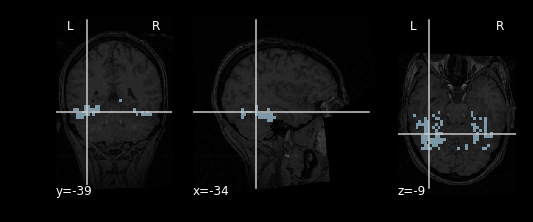

In [8]:
nplt.plot_roi(sub_mask[1], bg_img=sub_anat[1], cmap='Paired')
print('Mask on Top of Brain Anatomy (Subject 2)')
plt.show(block=False)

# Computing and Displaying Similarity Matrices 

Similarity matrices for the FMRI responses obtained from each subject is computed based on three different metrics; euclidean, cosine and correlation respectively. The computation is provided below together with the code that displays the similarity matrices:

In [9]:
# Compute similarity matrices using different metrics
sim_euclidean = cdist(data[1], data[1], metric='euclidean')
sim_cosine = cdist(data[1], data[1], metric='cosine')
sim_correlation = cdist(data[1], data[1], metric='correlation')

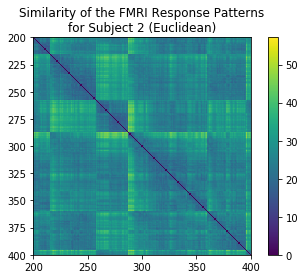

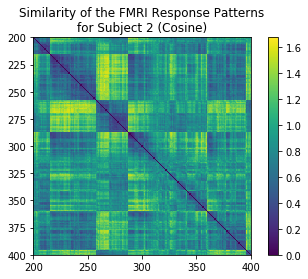

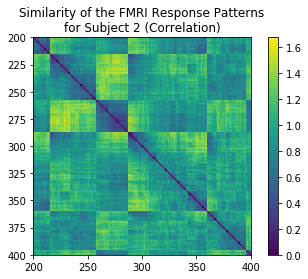

In [10]:
figure_num = 1
plt.figure(figure_num); figure_num += 1
plt.imshow(sim_euclidean); plt.colorbar()
plt.xlim(200, 400); plt.ylim(400, 200)
plt.title('Similarity of the FMRI Response Patterns\nfor Subject 2 (Euclidean)')

plt.figure(figure_num); figure_num += 1
plt.imshow(sim_cosine); plt.colorbar()
plt.xlim(200, 400); plt.ylim(400, 200)
plt.title('Similarity of the FMRI Response Patterns\nfor Subject 2 (Cosine)')

plt.figure(figure_num); figure_num += 1
plt.imshow(sim_correlation); plt.colorbar()
plt.xlim(200, 400); plt.ylim(400, 200)
plt.title('Similarity of the FMRI Response Patterns\nfor Subject 2 (Correlation)')
plt.show(block=False)

Looking at the outputs we see that correlation provides the best distinction. Hence, we proceed with the correlation based similarity matrix in our Multidimensional Scaling Analysis.

# Multidimensional Scaling Analysis 

In [11]:
def cmdscale(D):
    """
    Implementation of the classical multidimensional scaling (MDS) algorithm.
    Args:
        D: The symmetric matrix containing the distances between n 
            objects in p dimensions
    Returns:
        X: Coordinates of n objects in the new space
    """
    N = D.shape[0]
    # Double centering procedure
    J = np.eye(N) - np.ones((N, N)) / N
    B = - J.dot(D ** 2).dot(J) / 2 # = X.X^T
    # Diagonalization
    evals, evecs = np.linalg.eigh(B)
    # Sort eigenpairs according to the descending order of eigenvalues                                               
    idx = np.argsort(evals)[::-1]
    evals = evals[idx]
    evecs = evecs[:, idx]
    # Extract the positive eigenvalues 
    pos_idx = np.where(evals > 0)[0]
    L = np.diag(np.sqrt(evals[pos_idx]))
    E = evecs[:, pos_idx]
    X = E.dot(L)
    return X

Running the above method, we obtain the projections onto the first 3 MDs.

In [12]:
# Run classical MDS on correlation based similarity matrix
MDS_correlation = cmdscale(sim_correlation)[:, 0:3]

In [13]:
categories = sub_label[1]
categories = flatten(categories)

SCISSOR_INDICES = np.array([i for i in range(len(categories)) if categories[i] == 'scissors'])
FACE_INDICES = np.array([i for i in range(len(categories)) if categories[i] == 'face'])
CAT_INDICES = np.array([i for i in range(len(categories)) if categories[i] == 'cat'])
SCRAMBLEDPIX_INDICES = np.array([i for i in range(len(categories)) if categories[i] == 'scrambledpix'])
BOTTLE_INDICES = np.array([i for i in range(len(categories)) if categories[i] == 'bottle'])
CHAIR_INDICES = np.array([i for i in range(len(categories)) if categories[i] == 'chair'])
SHOE_INDICES = np.array([i for i in range(len(categories)) if categories[i] == 'shoe'])
HOUSE_INDICES = np.array([i for i in range(len(categories)) if categories[i] == 'house'])

Similarity data is scatterred and labeled in the 2-dimensional MD space. As it can be seen, there is no clear separation of data clusters, so multiclass classification is expected to perform poorly.

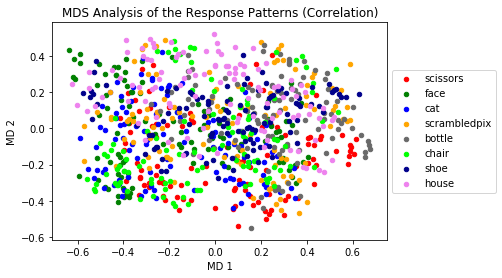

In [14]:
plt.figure(figure_num); figure_num += 1
colors_ = ['r', 'g', 'b', 'orange', 'dimgray', 'lime', 'darkblue', 'violet']
plt.scatter(MDS_correlation[SCISSOR_INDICES, 0], MDS_correlation[SCISSOR_INDICES, 1], s=20, marker='o', c=colors_[0])
plt.scatter(MDS_correlation[FACE_INDICES, 0], MDS_correlation[FACE_INDICES, 1], s=20, marker='o', c=colors_[1])
plt.scatter(MDS_correlation[CAT_INDICES, 0], MDS_correlation[CAT_INDICES, 1], s=20, marker='o', c=colors_[2])
plt.scatter(MDS_correlation[SCRAMBLEDPIX_INDICES, 0], MDS_correlation[SCRAMBLEDPIX_INDICES, 1], s=20, marker='o', c=colors_[3])
plt.scatter(MDS_correlation[BOTTLE_INDICES, 0], MDS_correlation[BOTTLE_INDICES, 1], s=20, marker='o', c=colors_[4])
plt.scatter(MDS_correlation[CHAIR_INDICES, 0], MDS_correlation[CHAIR_INDICES, 1], s=20, marker='o', c=colors_[5])
plt.scatter(MDS_correlation[SHOE_INDICES, 0], MDS_correlation[SHOE_INDICES, 1], s=20, marker='o', c=colors_[6])
plt.scatter(MDS_correlation[HOUSE_INDICES, 0], MDS_correlation[HOUSE_INDICES, 1], s=20, marker='o', c=colors_[7])
plt.xlabel('MD 1')
plt.ylabel('MD 2')
plt.title('MDS Analysis of the Response Patterns (Correlation)')
plt.legend(LABELS, loc='center left', bbox_to_anchor=(1, 0.5))
plt.show(block=False)

In [15]:
NONHOUSE_INDICES = np.array([i for i in range(len(categories)) if categories[i] != 'house'])

We now consider binary classification for each label. We show the scatter plot of similarity data of the data points labeled as house and others. As it can be seen, house data shifted up and a natural separation has occured.

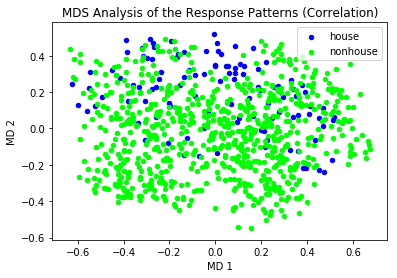

In [16]:
plt.figure(figure_num); figure_num += 1
plt.scatter(MDS_correlation[HOUSE_INDICES, 0], MDS_correlation[HOUSE_INDICES, 1], s=20, marker='o', c='b')
plt.scatter(MDS_correlation[NONHOUSE_INDICES, 0], MDS_correlation[NONHOUSE_INDICES, 1], s=20, marker='o', c='lime')
plt.xlabel('MD 1')
plt.ylabel('MD 2')
plt.title('MDS Analysis of the Response Patterns (Correlation)')
plt.legend(['house', 'nonhouse'])
plt.show(block=False)

We show the same data in 3-dimensional MDS space now. This time we can see a better distinction between the two data clouds. This is something expected, since higher number of dimensions mean more features that help determine the clusters. However, 3 dimensions is the best we can plot.

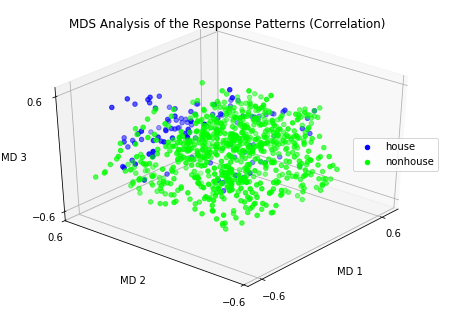

In [17]:
fig = plt.figure()
ax = Axes3D(fig)
ax.scatter(MDS_correlation[HOUSE_INDICES, 0], 
           MDS_correlation[HOUSE_INDICES, 1],
           MDS_correlation[HOUSE_INDICES, 2], color='b')
ax.scatter(MDS_correlation[NONHOUSE_INDICES, 0],
           MDS_correlation[NONHOUSE_INDICES, 1], 
           MDS_correlation[NONHOUSE_INDICES, 2], color='lime')
ax.view_init(elev=35, azim=220)
plt.title('MDS Analysis of the Response Patterns (Correlation)')
ax.set_xlabel('MD 1'); ax.set_ylabel('MD 2'); ax.set_zlabel('MD 3')
ax.set_xticks([-0.6, 0.6]); ax.set_yticks([-0.6, 0.6]); ax.set_zticks([-0.6, 0.6])
plt.legend(['house', 'nonhouse'], loc='center right')
plt.show(block=False)

# PCA or Mask?

We test the performance of the two reduction methods using the Support Vector Classifier. We see that Masking performs a lot better than PCA.

In [18]:
svc = SVC(C=1., kernel='linear')
cv = LeaveOneGroupOut()

cv = LeaveOneGroupOut()

GROUPS = np.repeat([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11], 72)
GROUPS_FOR_SUB5 = np.repeat([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10], 72)

scores_PCA = dict()
scores_Mask = dict()

for i in range(NUM_SUBJECTS):
    print('\n---SUBJECT %d---' % (i + 1))
    scores_PCA[i] = dict()
    scores_Mask[i] = dict()
    groups_ = GROUPS if i != 4 else GROUPS_FOR_SUB5
    for label in LABELS:
        print('Classification of %s' % label)
        classification_target = (labels[i] == label)
        scores_PCA[i][label] = cross_val_score(svc,
                                               data_PCA[i], 
                                               classification_target, 
                                               cv=cv, 
                                               groups=groups_,
                                               scoring='roc_auc')
        scores_Mask[i][label] = cross_val_score(svc,
                                                data[i], 
                                                classification_target, 
                                                cv=cv, 
                                                groups=groups_,
                                                scoring='roc_auc')
        print('Scores for PCA: %1.4f +- % 1.4f' % (scores_PCA[i][label].mean(), scores_PCA[i][label].std()))
        print('Scores for Mask: %1.4f +- % 1.4f' % (scores_Mask[i][label].mean(), scores_Mask[i][label].std()))


---SUBJECT 1---
Classification of scissors
Scores for PCA: 0.4866 +-  0.1617
Scores for Mask: 0.9566 +-  0.0798
Classification of face
Scores for PCA: 0.6662 +-  0.1624
Scores for Mask: 0.9875 +-  0.0331
Classification of cat
Scores for PCA: 0.3809 +-  0.2213
Scores for Mask: 0.9662 +-  0.0597
Classification of scrambledpix
Scores for PCA: 0.5367 +-  0.2289
Scores for Mask: 0.9985 +-  0.0044
Classification of bottle
Scores for PCA: 0.4242 +-  0.2234
Scores for Mask: 0.8779 +-  0.1208
Classification of chair
Scores for PCA: 0.3973 +-  0.1260
Scores for Mask: 0.9852 +-  0.0104
Classification of shoe
Scores for PCA: 0.5867 +-  0.2148
Scores for Mask: 0.9149 +-  0.0952
Classification of house
Scores for PCA: 0.5044 +-  0.1977
Scores for Mask: 1.0000 +-  0.0000

---SUBJECT 2---
Classification of scissors
Scores for PCA: 0.3861 +-  0.1493
Scores for Mask: 0.9215 +-  0.0707
Classification of face
Scores for PCA: 0.4975 +-  0.1620
Scores for Mask: 0.9835 +-  0.0192
Classification of cat
Score

In [19]:
reduction_names = ['PCA', 'Mask']
score_means_r = dict()
score_stds_r = dict()
for r_name in reduction_names:
    score_means_r[r_name] = dict()
    score_stds_r[r_name] = dict()
    for label in LABELS:
        sum_mean = 0
        sum_std = 0
        for i in range(NUM_SUBJECTS):
            if r_name == 'PCA':
                sum_mean += scores_PCA[i][label].mean()
                sum_std += scores_PCA[i][label].std()
            elif r_name == 'Mask':
                sum_mean += scores_Mask[i][label].mean()
                sum_std += scores_Mask[i][label].std()
        score_means_r[r_name][label] = sum_mean / NUM_SUBJECTS
        score_stds_r[r_name][label] = sum_std / NUM_SUBJECTS

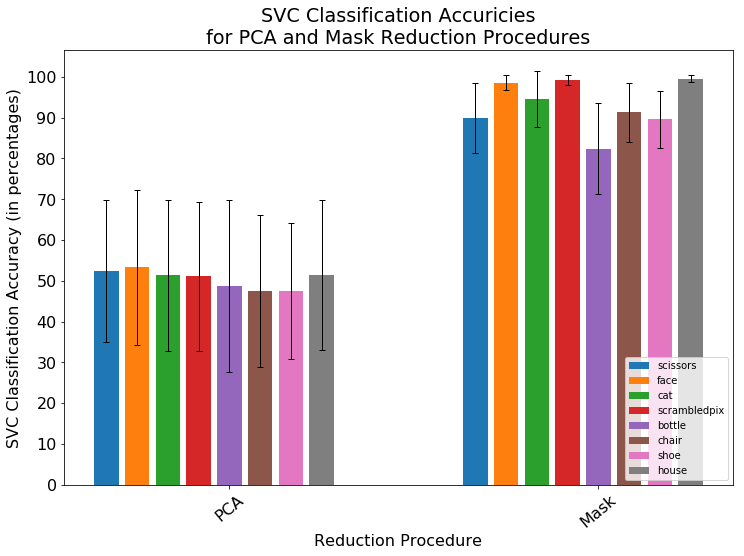

In [20]:
reduction_names = ['PCA', 'Mask']
plt.figure(figure_num, figsize=(12, 8)); figure_num += 1
plt.rcParams.update({'font.size': 16})
plt.title('SVC Classification Accuricies\nfor PCA and Mask Reduction Procedures')
plt.xlabel('Reduction Procedure')
plt.ylabel('SVC Classification Accuracy (in percentages)')
plt.xticks([i * NUM_STIMULI * 1.5 + 4 for i in range(len(reduction_names))], 
           reduction_names,
           rotation=40)
plt.yticks([i / 10 for i in range(11)], [i * 10 for i in range(11)])
for i, label in enumerate(LABELS):
    plt.bar(x=[j * NUM_STIMULI * 1.5 + i for j in range(len(reduction_names))], 
            height=[score_means_r[r_name][label] for r_name in reduction_names],
            yerr=[score_stds_r[r_name][label] for r_name in reduction_names],
            error_kw=dict(lw=1, capsize=3, capthick=1))
plt.rcParams.update({'font.size': 10})
plt.legend(LABELS, loc='lower right')
plt.show(block=False)

# Running Different Classification Algorithms

The following classification algorithms are used from the SciKit-Learn library, some of them were eliminated after seeing that they performed poorly. 

In [21]:
corr_matrix = np.corrcoef(data[1])
print('For subject 2\'s FMRI responses:')
print('Determinant of the correlation matrix:', np.linalg.det(corr_matrix))
print('Condition number of the correlation matrix:', np.linalg.cond(corr_matrix))

For subject 2's FMRI responses:
Determinant of the correlation matrix: 0.0
Condition number of the correlation matrix: 3.1092651299723424e+19


In [22]:
%%time
print('Takes a bit of time...')

classifiers = [
    KNeighborsClassifier(2),
    SVC(C=1., kernel='linear'),
    DecisionTreeClassifier(),
    #RandomForestClassifier(),
    #AdaBoostClassifier(),
    #GradientBoostingClassifier(),
    GaussianNB(),
    LinearDiscriminantAnalysis(),
    #QuadraticDiscriminantAnalysis(), # Variables are collinear
    MLPClassifier(alpha=1, max_iter=1000),
    LogisticRegression(solver='lbfgs')]

classifier_names = ['KNN',
                    'SVC',
                    'DecisionTree',
                    #'RandomForest', 
                    #'AdaBoost', 
                    #'GradientBoosting', 
                    'GaussianNB', 
                    'LDA',
                    #'QDA',
                    'MLP', 
                    'LogisticRegression']

cv = LeaveOneGroupOut()

scores = dict()

for clf, clf_name in zip(classifiers, classifier_names):
    print('Classification using %s:' % clf_name)
    scores[clf_name] = dict()
    for i in range(NUM_SUBJECTS):
        scores[clf_name][i] = dict()
        groups_ = GROUPS if i != 4 else GROUPS_FOR_SUB5
        for label in LABELS:
            classification_target = (labels[i] == label)
            scores[clf_name][i][label] = cross_val_score(clf,
                                                         data[i], 
                                                         classification_target, 
                                                         cv=cv, 
                                                         groups=groups_,
                                                         scoring='roc_auc')
        print('Subject %d done.' % (i + 1))

Takes a bit of time...
Classification using KNN:
Subject 1 done.
Subject 2 done.
Subject 3 done.
Subject 4 done.
Subject 5 done.
Subject 6 done.
Classification using SVC:
Subject 1 done.
Subject 2 done.
Subject 3 done.
Subject 4 done.
Subject 5 done.
Subject 6 done.
Classification using DecisionTree:
Subject 1 done.
Subject 2 done.
Subject 3 done.
Subject 4 done.
Subject 5 done.
Subject 6 done.
Classification using GaussianNB:
Subject 1 done.
Subject 2 done.
Subject 3 done.
Subject 4 done.
Subject 5 done.
Subject 6 done.
Classification using LDA:
Subject 1 done.
Subject 2 done.
Subject 3 done.
Subject 4 done.
Subject 5 done.
Subject 6 done.
Classification using MLP:
Subject 1 done.
Subject 2 done.
Subject 3 done.
Subject 4 done.
Subject 5 done.
Subject 6 done.
Classification using LogisticRegression:


/Users/user/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/Users/user/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/Users/user/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/Users/user/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/Users/user/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterati

Subject 1 done.


/Users/user/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/Users/user/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/Users/user/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/Users/user/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/Users/user/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterati

/Users/user/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/Users/user/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/Users/user/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/Users/user/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/Users/user/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterati

Subject 2 done.


/Users/user/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/Users/user/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/Users/user/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/Users/user/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/Users/user/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterati

Subject 3 done.


/Users/user/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/Users/user/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/Users/user/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/Users/user/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/Users/user/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterati

/Users/user/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/Users/user/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/Users/user/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/Users/user/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/Users/user/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterati

Subject 4 done.


/Users/user/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/Users/user/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/Users/user/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/Users/user/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/Users/user/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterati

Subject 5 done.


/Users/user/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/Users/user/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/Users/user/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/Users/user/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/Users/user/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterati

Subject 6 done.
CPU times: user 35min 36s, sys: 27.3 s, total: 36min 4s
Wall time: 21min 24s


In [23]:
%%time
score_means = dict()
score_stds = dict()
for clf_name in classifier_names:
    score_means[clf_name] = dict()
    score_stds[clf_name] = dict()
    for label in LABELS:
        sum_mean = 0
        sum_std = 0
        for i in range(NUM_SUBJECTS):
            sum_mean += scores[clf_name][i][label].mean()
            sum_std += scores[clf_name][i][label].std()
        score_means[clf_name][label] = sum_mean / NUM_SUBJECTS
        score_stds[clf_name][label] = sum_std / NUM_SUBJECTS

CPU times: user 18.7 ms, sys: 543 µs, total: 19.2 ms
Wall time: 9.6 ms


In [24]:
print('--- SCORES ---\n')
for clf_name in classifier_names:
    print('=== Classifier %s ===\n' % clf_name)
    for label in LABELS:
        print('*** Prediction Accuracy Averaged Over All Subjects for Label %s ***' % label)
        print('%1.4f +- %1.4f\n' % (score_means[clf_name][label], score_stds[clf_name][label]))

--- SCORES ---

=== Classifier KNN ===

*** Prediction Accuracy Averaged Over All Subjects for Label scissors ***
0.6446 +- 0.1425

*** Prediction Accuracy Averaged Over All Subjects for Label face ***
0.8347 +- 0.0986

*** Prediction Accuracy Averaged Over All Subjects for Label cat ***
0.7128 +- 0.1194

*** Prediction Accuracy Averaged Over All Subjects for Label scrambledpix ***
0.8236 +- 0.1259

*** Prediction Accuracy Averaged Over All Subjects for Label bottle ***
0.6113 +- 0.1258

*** Prediction Accuracy Averaged Over All Subjects for Label chair ***
0.6962 +- 0.1124

*** Prediction Accuracy Averaged Over All Subjects for Label shoe ***
0.7100 +- 0.1073

*** Prediction Accuracy Averaged Over All Subjects for Label house ***
0.9317 +- 0.0650

=== Classifier SVC ===

*** Prediction Accuracy Averaged Over All Subjects for Label scissors ***
0.8992 +- 0.0864

*** Prediction Accuracy Averaged Over All Subjects for Label face ***
0.9853 +- 0.0186

*** Prediction Accuracy Averaged Over

The block below generates a plot that displays the prediction accuracies of each classification algorithm:

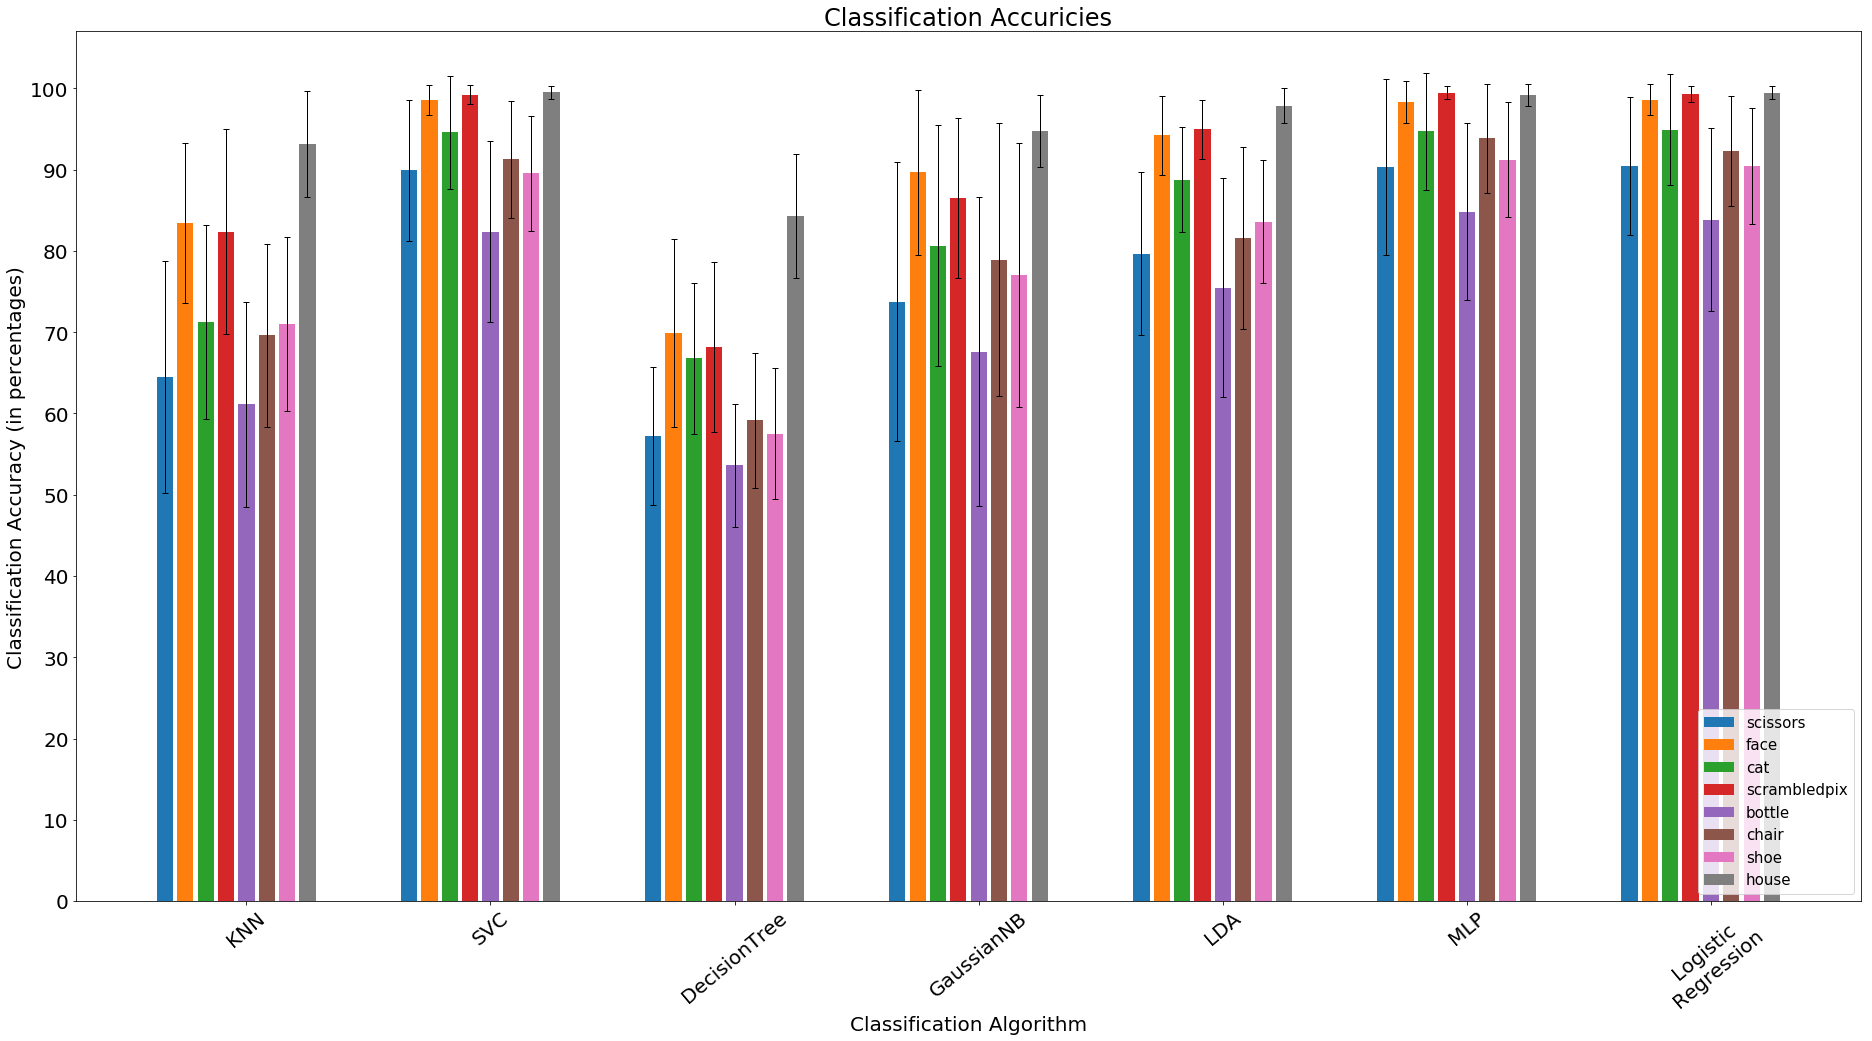

In [25]:
plt.figure(figure_num, figsize=(32, 16)); figure_num += 1
plt.rcParams.update({'font.size': 20})
plt.title('Classification Accuricies')
plt.xlabel('Classification Algorithm')
plt.ylabel('Classification Accuracy (in percentages)')
plt.xticks([i * NUM_STIMULI * 1.5 + 4 for i in range(len(classifier_names))], 
           classifier_names[0:(len(classifier_names) - 1)] + ['Logistic\nRegression'],
           rotation=40)
plt.yticks([i / 10 for i in range(11)], [i * 10 for i in range(11)])
for i, label in enumerate(LABELS):
    plt.bar(x=[j * NUM_STIMULI * 1.5 + i for j in range(len(classifier_names))], 
            height=[score_means[clf_name][label] for clf_name in classifier_names],
            yerr=[score_stds[clf_name][label] for clf_name in classifier_names],
            error_kw=dict(lw=1, capsize=3, capthick=1))
plt.rcParams.update({'font.size': 15})
plt.legend(LABELS, loc='lower right')
#plt.savefig('ClassificationResults.png')
plt.show(block=False)